In [4]:
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import transforms
import numpy as np
from utils.datasets import letterbox ## Resize and pad image while meeting stride-multiple constraints
from utils.general import non_max_suppression
from utils.plots import output_to_target, plot_skeleton_kpts

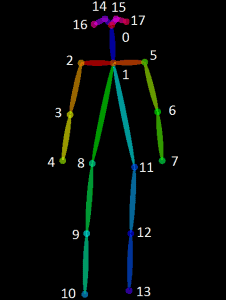

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [32]:
image = cv2.imread('data/BP.jpg')
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)   
output, _ = model(image)

In [33]:
"""
Runs Non-Maximum Suppression (NMS) on inference results

Returns:
     list of detections, on (n,6) tensor per image [xyxy, conf, cls]
"""
output = non_max_suppression(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)

# 4 output in a frame

with torch.no_grad():
    """
    Convert model output to target format [batch_id, class_id, x, y, w, h, conf]
    i, cls, *list(*xyxy2xywh(np.array(box)[None])), conf, *list(kpts.cpu().numpy()[index]
    
    i x1
    cls x1
    x y w h x1
    conf for xywh x1
    (kpts x2 + conf x1) x 17
    
    xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] 
    where xy1=top-left, xy2=bottom-right become x-center, y-center, width, height
    """
    output = output_to_target(output)
    print("how many people are there,",len(output))
    print("how many data in a detection","*"*10,output[0].shape)
    print(output[0])
    
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

how many people are there, 4
how many data in a detection ********** (58,)
[          0           0      530.39      315.36      200.25       469.1     0.93562      520.62      110.47     0.99577      529.35      105.65     0.98615      513.65      102.75       0.986      537.04       118.8     0.76198      496.53      110.44     0.82191      545.82      155.06     0.98702      474.41
      174.93     0.98644      609.09      180.44     0.96862      477.11      244.63     0.96589      568.82       228.7      0.9673      487.78      303.03     0.96497      560.62      289.21     0.99186      507.62      293.82     0.99167      585.24      395.84     0.98679      474.05      395.96     0.98695
      606.97      508.12     0.94907      478.55      509.39     0.95051]


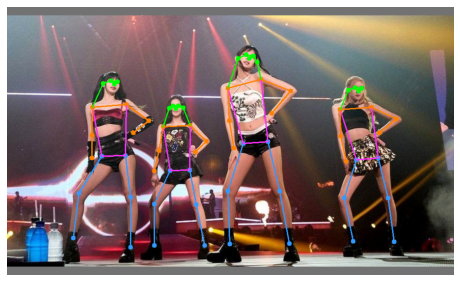

In [35]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()